# IIT 4316 Deep Learning<br>Homework #2-2: Transformer

# 1. Define.

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import math
from tqdm import tqdm as tq

DIGITS     = ['0','1','2','3','4','5','6','7','8','9']
VOCAB_SIZE = len(DIGITS)
DEVICE     = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

# Fixed hyperparameters
INPUT_LEN     = 4
OUTPUT_LEN    = 3
LEARNING_RATE = 6e-3
NUM_EPOCH     = 5000
BATCH_SIZE    = 128

# Changable hyperparameters
EMBED_DIM         = 4
ENCODER_LAYER_NUM = 2
HIDDEN_DIM        = 32

char_to_idx = {c:i for i,c in enumerate(DIGITS)}
idx_to_char = {i:c for i,c in enumerate(DIGITS)}

# batch data generation
def generate_batch(batch_size=100):
    inputs, targets = [], []
    for _ in range(batch_size):
        tens1, ones1 = random.randint(0, 9), random.randint(0, 9)
        tens2, ones2 = random.randint(0, 9), random.randint(0, 9)
        num1, num2 = tens1 * 10 + ones1, tens2 * 10 + ones2
        s = num1 + num2
        inputs.append([tens1, ones1, tens2, ones2])
        sum_str = f"{s:03d}"
        targets.append([char_to_idx[c] for c in sum_str])
    return (torch.tensor(inputs, dtype=torch.long).to(DEVICE),
            torch.tensor(targets, dtype=torch.long).to(DEVICE))

# ReLU
def my_relu(x):
    return torch.clamp(x, min=0.0)

#------------------------------------
# Layer Normalization (for stability with large dimensions)
#------------------------------------
class MyLayerNorm(nn.Module):
    def __init__(self, dim, eps=5e-3):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta  = nn.Parameter(torch.zeros(dim))
        self.eps   = eps
    
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std  = x.std(dim=-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

#------------------------------------
# Positional Encoding (sinusoidal)
#------------------------------------
class MyPositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=100):
        super().__init__()
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        if embed_dim % 2 == 0:
            pe[:, 1::2] = torch.cos(position * div_term)
        else:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        
        # Register as buffer (not a parameter, but should be saved/loaded)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, embed_dim)
    
    def forward(self, x):
        # x: (B, L, embed_dim)
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]

#------------------------------------
# 4 digits to one-hot vectors
#------------------------------------
def MyOneHot(x, vocab_size):    
    B, L = x.size()     # batch size x INPUT_LEN

    ############################################################################
    # TODO: Convert x to one-hot
    ############################################################################

    # Create zero tensor of shape (B, L, vocab_size)
    out = torch.zeros(B, L, vocab_size, device=x.device)
    # Use scatter to fill in the one-hot encoding
    out.scatter_(2, x.unsqueeze(2), 1.0)

    ############################################################################
    # END TODO
    ############################################################################

    return out   # B x L x vocab_size

#------------------------------------
# Embedding layer
#------------------------------------
class MyEmbedding(nn.Module):
    def __init__(self, vocab_size, dim):
        super().__init__()
        # Xavier initialization for stability
        self.weight = nn.Parameter(torch.randn(vocab_size, dim) * math.sqrt(2.0 / (vocab_size + dim)))

    def forward(self, x):
        B, L = x.size()

        ############################################################################
        # TODO: Convert x to one-hot and then embedding
        #    Use MyOneHot() function above.
        ############################################################################

        # Convert to one-hot: (B, L, vocab_size)
        one_hot = MyOneHot(x, self.weight.size(0))
        # Matrix multiply with embedding weight: (B, L, vocab_size) @ (vocab_size, dim) = (B, L, dim)
        out = torch.matmul(one_hot, self.weight)
        
        ############################################################################
        # END TODO
        ############################################################################

        return out  # B x L x dim

#------------------------------------
# Linear layer
#------------------------------------
class MyLinear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        # Xavier initialization for stability
        self.weight = nn.Parameter(torch.randn(out_dim, in_dim) * math.sqrt(2.0 / (in_dim + out_dim)))
        self.bias   = nn.Parameter(torch.zeros(out_dim))

    def forward(self, x):

        ############################################################################
        # TODO: Compute linear layer output
        #   You should implement your own linear layer operation.
        ############################################################################
            
        # x: (..., in_dim), weight: (out_dim, in_dim), bias: (out_dim)
        # out = x @ W^T + bias
        out = torch.matmul(x, self.weight.t()) + self.bias
        
        ############################################################################
        # END TODO
        ############################################################################

        return out  

#------------------------------------
# Self-attention operation
#------------------------------------
class MySelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()

        ############################################################################
        # TODO: Define operations to obtain query, key, value from x.
        #   Use MyLinear class defined above.
        ############################################################################

        self.embed_dim = embed_dim
        self.query     = MyLinear(embed_dim, embed_dim)
        self.key       = MyLinear(embed_dim, embed_dim)
        self.value     = MyLinear(embed_dim, embed_dim)

        ############################################################################
        # END TODO
        ############################################################################

    def forward(self, x):

        ############################################################################
        # TODO: Scaled dot-product attention
        #  You should implement your own self-attention operation.
        #  You can use F.softmax for softmax operation and math.sqrt for square root operation.
        ############################################################################

        # x: (B, L, embed_dim)
        Q = self.query(x)  # (B, L, embed_dim)
        K = self.key(x)    # (B, L, embed_dim)
        V = self.value(x)  # (B, L, embed_dim)
        
        # Scaled dot-product attention
        # scores = Q @ K^T / sqrt(d_k)
        d_k    = self.embed_dim
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)  # (B, L, L)
        
        # Softmax over the last dimension
        attn_weights = F.softmax(scores, dim=-1)  # (B, L, L)
        
        # Apply attention to values
        attn_output = torch.matmul(attn_weights, V)  # (B, L, embed_dim)
        
        # Skip connection
        out = attn_output + x
        
        ############################################################################
        # END TODO
        ############################################################################

        return out

#------------------------------------
# Encoder layer
#------------------------------------
class MyEncoderLayer(nn.Module):
    def __init__(self, embed_dim, hidden_dim, use_layer_norm=True):
        super().__init__()
        self.use_layer_norm = use_layer_norm

        ############################################################################
        # TODO: Define each sub-layer (self-attention, linear1, linear2)
        #   Use MyLinear class defined above.
        ############################################################################

        self.self_attention = MySelfAttention(embed_dim)
        # 2-layer MLP: embed_dim -> hidden_dim -> embed_dim
        self.linear1 = MyLinear(embed_dim, hidden_dim)
        self.linear2 = MyLinear(hidden_dim, embed_dim)
        
        # Layer Normalization for stability (optional)
        if use_layer_norm:
            self.norm1 = MyLayerNorm(embed_dim)
            self.norm2 = MyLayerNorm(embed_dim)
        
        ############################################################################
        # END TODO
        ############################################################################

    def forward(self, x):

        ############################################################################
        # TODO: Define forward path:  
        #    self-attention (with skip) -> 2-layer MLP (with skip)
        ############################################################################

        # Self-attention with skip connection (already included in MySelfAttention)
        x = self.self_attention(x)  # (B, L, embed_dim)
        if self.use_layer_norm:
            x = self.norm1(x)           # Layer Normalization
        
        # 2-layer MLP with skip connection
        mlp_out = self.linear1(x)       # (B, L, hidden_dim)
        mlp_out = my_relu(mlp_out)      # ReLU activation
        mlp_out = self.linear2(mlp_out) # (B, L, embed_dim)
        
        # Skip connection for MLP
        out = mlp_out + x
        if self.use_layer_norm:
            out = self.norm2(out)           # Layer Normalization

        ############################################################################
        # END TODO
        ############################################################################
        
        return out     

# --------------------
# Transformer model
# --------------------
class MyTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_encoder_layers, 
                 use_layer_norm=True, use_positional_encoding=True):
        super().__init__()
        
        ############################################################################
        # TODO: Define each layer (embedding, enc1, enc2, ..., fc).
        #   Use MyEmbedding, MyEncoderLayer, MyLinear classes defined above.
        ############################################################################

        self.embed_dim               = embed_dim
        self.num_encoder_layers      = num_encoder_layers
        self.use_layer_norm          = use_layer_norm
        self.use_positional_encoding = use_positional_encoding
        
        # Embedding layer
        self.embedding = MyEmbedding(vocab_size, embed_dim)
        
        # Positional Encoding (optional)
        if use_positional_encoding:
            self.positional_encoding = MyPositionalEncoding(embed_dim, max_len=INPUT_LEN)
        
        # Encoder layers using nn.ModuleList for dynamic number of layers
        self.encoder_layers = nn.ModuleList()
        for _ in range(num_encoder_layers):
            self.encoder_layers.append(MyEncoderLayer(embed_dim, hidden_dim, use_layer_norm))
        
        # FC layer: input is flattened encoder output (INPUT_LEN * embed_dim), output is OUTPUT_LEN * VOCAB_SIZE
        self.fc = MyLinear(INPUT_LEN * embed_dim, OUTPUT_LEN * vocab_size)

        ############################################################################
        # END TODO
        ############################################################################

    def forward(self, x):

        ############################################################################
        # TODO: Define forward path 
        #   embedding -> encoder layer 1 -> encoder layer 2 -> ... -> flatten -> linear layer
        ############################################################################

        B = x.size(0)
        
        # Embedding: (B, 4) -> (B, 4, embed_dim)
        out = self.embedding(x)
        
        # Add positional encoding if enabled
        if self.use_positional_encoding:
            out = self.positional_encoding(out)
        
        # Apply encoder layers
        for encoder in self.encoder_layers:
            out = encoder(out)  # (B, 4, embed_dim)
        
        # Flatten: (B, 4, embed_dim) -> (B, 4 * embed_dim)
        out = out.view(B, -1)
        
        # FC layer: (B, 4 * embed_dim) -> (B, 3 * VOCAB_SIZE)
        out = self.fc(out)
        
        # Reshape to (B, 3, VOCAB_SIZE)
        out = out.view(B, OUTPUT_LEN, VOCAB_SIZE)

        ############################################################################
        # END TODO
        ############################################################################

        return out    # B x 3 x VOCAB_SIZE


# 2. Run.

In [45]:
# --------------------
# Training & test
# --------------------
torch.manual_seed(42)
random.seed(42)

model     = MyTransformer(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, ENCODER_LAYER_NUM).to(DEVICE)
optim     = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

for epoch in tq(range(1, NUM_EPOCH+1)):
    model.train()
    src, tgt = generate_batch(BATCH_SIZE)
    logits   = model(src)
    loss     = criterion(logits.view(-1, VOCAB_SIZE), tgt.view(-1))

    optim.zero_grad()
    loss.backward()
    
    # Gradient Clipping to prevent explosion
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optim.step()

    if epoch % 50 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d}  Loss: {loss.item():.4f}")

# Evaluation
model.eval()
correct = 0
total   = 0
with torch.no_grad():
    src, tgt = generate_batch(1000)
    logits   = model(src)
    preds    = logits.argmax(-1)
    for s, t, p in zip(src.cpu().tolist(), tgt.cpu().tolist(), preds.cpu().tolist()):
        s_str = f"{s[0]}{s[1]} + {s[2]}{s[3]}"
        t_str = ''.join(idx_to_char[x] for x in t)
        p_str = ''.join(idx_to_char[x] for x in p)
        print(f"src: {s_str} = {t_str} | pred: {p_str}")
        if t_str == p_str:
            correct += 1
        total += 1
print(f"Correct: {correct}/{total}")


  0%|          | 0/5000 [00:00<?, ?it/s]

  1%|          | 26/5000 [00:00<00:39, 125.83it/s]

Epoch 001  Loss: 2.5505


  1%|▏         | 66/5000 [00:00<00:38, 128.75it/s]

Epoch 050  Loss: 1.7627


  2%|▏         | 124/5000 [00:00<00:35, 136.67it/s]

Epoch 100  Loss: 1.6250


  3%|▎         | 169/5000 [00:01<00:34, 141.37it/s]

Epoch 150  Loss: 1.5176


  4%|▍         | 213/5000 [00:01<00:34, 137.54it/s]

Epoch 200  Loss: 1.4479


  5%|▌         | 272/5000 [00:01<00:33, 140.26it/s]

Epoch 250  Loss: 1.3583


  6%|▋         | 317/5000 [00:02<00:32, 142.32it/s]

Epoch 300  Loss: 1.2383


  8%|▊         | 377/5000 [00:02<00:32, 141.54it/s]

Epoch 350  Loss: 1.0692


  8%|▊         | 422/5000 [00:03<00:32, 139.56it/s]

Epoch 400  Loss: 0.9820


  9%|▉         | 465/5000 [00:03<00:32, 137.75it/s]

Epoch 450  Loss: 0.7965


 10%|█         | 524/5000 [00:03<00:31, 142.90it/s]

Epoch 500  Loss: 0.5724


 11%|█▏        | 569/5000 [00:04<00:30, 143.25it/s]

Epoch 550  Loss: 0.4843


 12%|█▏        | 614/5000 [00:04<00:31, 141.37it/s]

Epoch 600  Loss: 0.4578


 13%|█▎        | 674/5000 [00:04<00:29, 145.08it/s]

Epoch 650  Loss: 0.3735


 14%|█▍        | 719/5000 [00:05<00:29, 145.21it/s]

Epoch 700  Loss: 0.3463


 16%|█▌        | 779/5000 [00:05<00:29, 145.19it/s]

Epoch 750  Loss: 0.3128


 16%|█▋        | 824/5000 [00:05<00:28, 145.59it/s]

Epoch 800  Loss: 0.4405


 17%|█▋        | 869/5000 [00:06<00:30, 137.50it/s]

Epoch 850  Loss: 0.2947


 19%|█▊        | 929/5000 [00:06<00:28, 143.46it/s]

Epoch 900  Loss: 0.2568


 19%|█▉        | 974/5000 [00:06<00:27, 146.85it/s]

Epoch 950  Loss: 0.2480


 20%|██        | 1019/5000 [00:07<00:27, 145.58it/s]

Epoch 1000  Loss: 0.2339


 22%|██▏       | 1079/5000 [00:07<00:27, 145.06it/s]

Epoch 1050  Loss: 0.2212


 22%|██▏       | 1124/5000 [00:07<00:27, 142.19it/s]

Epoch 1100  Loss: 0.1814


 23%|██▎       | 1169/5000 [00:08<00:28, 134.76it/s]

Epoch 1150  Loss: 0.1955


 25%|██▍       | 1226/5000 [00:08<00:26, 139.99it/s]

Epoch 1200  Loss: 0.1459


 25%|██▌       | 1271/5000 [00:09<00:25, 143.60it/s]

Epoch 1250  Loss: 0.1634


 26%|██▋       | 1316/5000 [00:09<00:25, 145.22it/s]

Epoch 1300  Loss: 0.1497


 28%|██▊       | 1376/5000 [00:09<00:24, 145.11it/s]

Epoch 1350  Loss: 0.1330


 28%|██▊       | 1421/5000 [00:10<00:25, 139.03it/s]

Epoch 1400  Loss: 0.1255


 29%|██▉       | 1465/5000 [00:10<00:25, 136.04it/s]

Epoch 1450  Loss: 0.1465


 30%|███       | 1523/5000 [00:10<00:24, 142.84it/s]

Epoch 1500  Loss: 0.1119


 31%|███▏      | 1568/5000 [00:11<00:24, 141.30it/s]

Epoch 1550  Loss: 0.1067


 33%|███▎      | 1628/5000 [00:11<00:23, 142.85it/s]

Epoch 1600  Loss: 0.1392


 33%|███▎      | 1673/5000 [00:11<00:24, 138.54it/s]

Epoch 1650  Loss: 0.1007


 34%|███▍      | 1718/5000 [00:12<00:22, 144.13it/s]

Epoch 1700  Loss: 0.1052


 36%|███▌      | 1778/5000 [00:12<00:22, 145.02it/s]

Epoch 1750  Loss: 0.0989


 36%|███▋      | 1824/5000 [00:12<00:21, 147.06it/s]

Epoch 1800  Loss: 0.1170


 37%|███▋      | 1869/5000 [00:13<00:22, 137.96it/s]

Epoch 1850  Loss: 0.1868


 38%|███▊      | 1914/5000 [00:13<00:21, 141.84it/s]

Epoch 1900  Loss: 0.0866


 40%|███▉      | 1975/5000 [00:14<00:20, 144.27it/s]

Epoch 1950  Loss: 0.1404


 40%|████      | 2020/5000 [00:14<00:20, 144.45it/s]

Epoch 2000  Loss: 0.0926


 41%|████▏     | 2065/5000 [00:14<00:21, 136.51it/s]

Epoch 2050  Loss: 0.0707


 42%|████▎     | 2125/5000 [00:15<00:20, 143.41it/s]

Epoch 2100  Loss: 0.0900


 43%|████▎     | 2170/5000 [00:15<00:20, 141.41it/s]

Epoch 2150  Loss: 0.0523


 45%|████▍     | 2229/5000 [00:15<00:19, 141.60it/s]

Epoch 2200  Loss: 0.0664


 45%|████▌     | 2274/5000 [00:16<00:19, 139.54it/s]

Epoch 2250  Loss: 0.0797


 46%|████▋     | 2319/5000 [00:16<00:18, 143.28it/s]

Epoch 2300  Loss: 0.0845


 48%|████▊     | 2379/5000 [00:16<00:18, 144.53it/s]

Epoch 2350  Loss: 0.0937


 48%|████▊     | 2424/5000 [00:17<00:18, 139.61it/s]

Epoch 2400  Loss: 0.0660


 49%|████▉     | 2468/5000 [00:17<00:17, 140.83it/s]

Epoch 2450  Loss: 0.0699


 51%|█████     | 2529/5000 [00:17<00:17, 142.12it/s]

Epoch 2500  Loss: 0.0393


 51%|█████▏    | 2574/5000 [00:18<00:16, 143.93it/s]

Epoch 2550  Loss: 0.0443


 52%|█████▏    | 2619/5000 [00:18<00:16, 142.08it/s]

Epoch 2600  Loss: 0.0268


 54%|█████▎    | 2679/5000 [00:19<00:16, 142.40it/s]

Epoch 2650  Loss: 0.1146


 54%|█████▍    | 2724/5000 [00:19<00:16, 142.01it/s]

Epoch 2700  Loss: 0.0359


 55%|█████▌    | 2769/5000 [00:19<00:16, 137.36it/s]

Epoch 2750  Loss: 0.0308


 57%|█████▋    | 2829/5000 [00:20<00:14, 145.06it/s]

Epoch 2800  Loss: 0.0323


 57%|█████▋    | 2874/5000 [00:20<00:15, 136.33it/s]

Epoch 2850  Loss: 0.0851


 58%|█████▊    | 2919/5000 [00:20<00:14, 140.08it/s]

Epoch 2900  Loss: 0.0205


 60%|█████▉    | 2978/5000 [00:21<00:14, 137.40it/s]

Epoch 2950  Loss: 0.0911


 60%|██████    | 3023/5000 [00:21<00:13, 141.45it/s]

Epoch 3000  Loss: 0.0396


 61%|██████▏   | 3068/5000 [00:21<00:14, 137.12it/s]

Epoch 3050  Loss: 0.0196


 63%|██████▎   | 3128/5000 [00:22<00:12, 144.33it/s]

Epoch 3100  Loss: 0.0056


 63%|██████▎   | 3173/5000 [00:22<00:13, 136.56it/s]

Epoch 3150  Loss: 0.0031


 64%|██████▍   | 3218/5000 [00:22<00:12, 140.91it/s]

Epoch 3200  Loss: 0.0032


 66%|██████▌   | 3278/5000 [00:23<00:12, 136.55it/s]

Epoch 3250  Loss: 0.0065


 66%|██████▋   | 3321/5000 [00:23<00:12, 136.79it/s]

Epoch 3300  Loss: 0.0042


 67%|██████▋   | 3366/5000 [00:24<00:11, 137.46it/s]

Epoch 3350  Loss: 0.0047


 69%|██████▊   | 3426/5000 [00:24<00:11, 142.58it/s]

Epoch 3400  Loss: 0.0017


 69%|██████▉   | 3471/5000 [00:24<00:11, 134.24it/s]

Epoch 3450  Loss: 0.0075


 70%|███████   | 3515/5000 [00:25<00:10, 140.78it/s]

Epoch 3500  Loss: 0.0028


 72%|███████▏  | 3575/5000 [00:25<00:10, 139.03it/s]

Epoch 3550  Loss: 0.0018


 72%|███████▏  | 3621/5000 [00:25<00:09, 143.91it/s]

Epoch 3600  Loss: 0.0022


 73%|███████▎  | 3665/5000 [00:26<00:09, 137.19it/s]

Epoch 3650  Loss: 0.0008


 74%|███████▍  | 3725/5000 [00:26<00:08, 142.09it/s]

Epoch 3700  Loss: 0.0011


 75%|███████▌  | 3771/5000 [00:26<00:08, 139.51it/s]

Epoch 3750  Loss: 0.0008


 76%|███████▋  | 3816/5000 [00:27<00:08, 134.94it/s]

Epoch 3800  Loss: 0.0008


 78%|███████▊  | 3875/5000 [00:27<00:07, 141.84it/s]

Epoch 3850  Loss: 0.0008


 78%|███████▊  | 3920/5000 [00:28<00:07, 135.67it/s]

Epoch 3900  Loss: 0.0011


 80%|███████▉  | 3979/5000 [00:28<00:07, 141.68it/s]

Epoch 3950  Loss: 0.0006


 80%|████████  | 4023/5000 [00:28<00:07, 132.86it/s]

Epoch 4000  Loss: 0.0005


 81%|████████▏ | 4066/5000 [00:29<00:07, 131.75it/s]

Epoch 4050  Loss: 0.0007


 82%|████████▎ | 4125/5000 [00:29<00:06, 140.98it/s]

Epoch 4100  Loss: 0.0004


 83%|████████▎ | 4170/5000 [00:29<00:06, 135.83it/s]

Epoch 4150  Loss: 0.0004


 85%|████████▍ | 4228/5000 [00:30<00:05, 141.42it/s]

Epoch 4200  Loss: 0.0005


 85%|████████▌ | 4273/5000 [00:30<00:05, 136.86it/s]

Epoch 4250  Loss: 0.0004


 86%|████████▋ | 4317/5000 [00:30<00:04, 141.75it/s]

Epoch 4300  Loss: 0.0004


 88%|████████▊ | 4377/5000 [00:31<00:04, 138.92it/s]

Epoch 4350  Loss: 0.0004


 88%|████████▊ | 4420/5000 [00:31<00:04, 139.00it/s]

Epoch 4400  Loss: 0.0004


 90%|████████▉ | 4479/5000 [00:32<00:03, 140.32it/s]

Epoch 4450  Loss: 0.0003


 90%|█████████ | 4524/5000 [00:32<00:03, 134.76it/s]

Epoch 4500  Loss: 0.0003


 91%|█████████▏| 4569/5000 [00:32<00:03, 133.43it/s]

Epoch 4550  Loss: 0.0003


 93%|█████████▎| 4628/5000 [00:33<00:02, 136.55it/s]

Epoch 4600  Loss: 0.0003


 93%|█████████▎| 4672/5000 [00:33<00:02, 133.28it/s]

Epoch 4650  Loss: 0.0003


 94%|█████████▍| 4717/5000 [00:33<00:02, 133.81it/s]

Epoch 4700  Loss: 0.0003


 96%|█████████▌| 4775/5000 [00:34<00:01, 139.32it/s]

Epoch 4750  Loss: 0.0003


 96%|█████████▋| 4818/5000 [00:34<00:01, 134.64it/s]

Epoch 4800  Loss: 0.0003


 98%|█████████▊| 4877/5000 [00:35<00:00, 134.89it/s]

Epoch 4850  Loss: 0.0002


 98%|█████████▊| 4917/5000 [00:35<00:00, 123.94it/s]

Epoch 4900  Loss: 0.0002


 99%|█████████▉| 4974/5000 [00:35<00:00, 132.62it/s]

Epoch 4950  Loss: 0.0002


100%|██████████| 5000/5000 [00:36<00:00, 138.37it/s]

Epoch 5000  Loss: 0.0002
src: 90 + 68 = 158 | pred: 158
src: 39 + 39 = 078 | pred: 078
src: 70 + 82 = 152 | pred: 152
src: 15 + 36 = 051 | pred: 051
src: 39 + 00 = 039 | pred: 039
src: 26 + 26 = 052 | pred: 052
src: 18 + 13 = 031 | pred: 031
src: 85 + 17 = 102 | pred: 102
src: 29 + 03 = 032 | pred: 032
src: 57 + 95 = 152 | pred: 152
src: 50 + 02 = 052 | pred: 052
src: 11 + 59 = 070 | pred: 070
src: 61 + 96 = 157 | pred: 157
src: 51 + 28 = 079 | pred: 079
src: 82 + 28 = 110 | pred: 110
src: 73 + 05 = 078 | pred: 078
src: 33 + 62 = 095 | pred: 095
src: 42 + 05 = 047 | pred: 047
src: 03 + 74 = 077 | pred: 077
src: 85 + 17 = 102 | pred: 102
src: 26 + 51 = 077 | pred: 077
src: 02 + 29 = 031 | pred: 031
src: 71 + 13 = 084 | pred: 084
src: 75 + 66 = 141 | pred: 141
src: 22 + 80 = 102 | pred: 102
src: 52 + 74 = 126 | pred: 126
src: 95 + 82 = 177 | pred: 177
src: 07 + 42 = 049 | pred: 049
src: 44 + 65 = 109 | pred: 109
src: 81 + 45 = 126 | pred: 126
src: 01 + 47 = 048 | pred: 048
src: 93 + 02 =

# 3. Plotting.

## 3.1. Hyperparameter Experiments

In [13]:
import matplotlib.pyplot as plt
import time
from tqdm import tqdm as tq

# ============================================================
# Hyperparameter Experiment for Transformer
# ============================================================

def train_and_evaluate(vocab_size, embed_dim, hidden_dim, num_encoder_layers, 
                       num_epochs=1000, batch_size=128, lr=10e-3, test_size=1000):
    """Train model and return final loss, test accuracy, and training time."""
    torch.manual_seed(42)
    random.seed(42)
    
    model     = MyTransformer(vocab_size, embed_dim, hidden_dim, num_encoder_layers).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # Training with time measurement
    start_time = time.time()
    final_loss = 0
    for epoch in range(1, num_epochs + 1):
        model.train()
        src, tgt = generate_batch(batch_size)
        logits   = model(src)
        loss     = criterion(logits.view(-1, VOCAB_SIZE), tgt.view(-1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        final_loss = loss.item()
    train_time = time.time() - start_time
    
    # Evaluation
    model.eval()
    correct = 0
    with torch.no_grad():
        src, tgt = generate_batch(test_size)
        logits   = model(src)
        preds    = logits.argmax(-1)
        for t, p in zip(tgt.cpu().tolist(), preds.cpu().tolist()):
            if t == p:
                correct += 1
    
    return final_loss, correct, train_time

# Default values
DEFAULT_EMBED_DIM         = 64
DEFAULT_ENCODER_LAYER_NUM = 2
DEFAULT_HIDDEN_DIM        = 128

# ============================================================
# Experiment 1: Varying EMBED_DIM
# ============================================================
print("=" * 50)
print("Experiment 1: Varying EMBED_DIM")
print("=" * 50)

embed_dims   = [4, 8, 16, 32, 64, 128, 256, 512]
losses_embed = []
accs_embed   = []
times_embed  = []

for ed in tq(embed_dims, desc="EMBED_DIM"):
    loss, acc, t = train_and_evaluate(VOCAB_SIZE, ed, DEFAULT_HIDDEN_DIM, DEFAULT_ENCODER_LAYER_NUM)
    losses_embed.append(loss)
    accs_embed.append(acc)
    times_embed.append(t)
    print(f"EMBED_DIM={ed:3d} | Loss: {loss:.4f} | Correct: {acc}/1000 | Time: {t:.2f}s")

# ============================================================
# Experiment 2: Varying ENCODER_LAYER_NUM
# ============================================================
print("\n" + "=" * 50)
print("Experiment 2: Varying ENCODER_LAYER_NUM")
print("=" * 50)

encoder_layers = [1, 2, 3, 4, 5, 6, 7, 8]
losses_encoder = []
accs_encoder   = []
times_encoder  = []

for nl in tq(encoder_layers, desc="ENCODER_LAYER_NUM"):
    loss, acc, t = train_and_evaluate(VOCAB_SIZE, DEFAULT_EMBED_DIM, DEFAULT_HIDDEN_DIM, nl)
    losses_encoder.append(loss)
    accs_encoder.append(acc)
    times_encoder.append(t)
    print(f"ENCODER_LAYER_NUM={nl} | Loss: {loss:.4f} | Correct: {acc}/1000 | Time: {t:.2f}s")

# ============================================================
# Experiment 3: Varying HIDDEN_DIM
# ============================================================
print("\n" + "=" * 50)
print("Experiment 3: Varying HIDDEN_DIM")
print("=" * 50)

hidden_dims   = [4, 8, 16, 32, 64, 128, 256, 512]
losses_hidden = []
accs_hidden   = []
times_hidden  = []

for hd in tq(hidden_dims, desc="HIDDEN_DIM"):
    loss, acc, t = train_and_evaluate(VOCAB_SIZE, DEFAULT_EMBED_DIM, hd, DEFAULT_ENCODER_LAYER_NUM)
    losses_hidden.append(loss)
    accs_hidden.append(acc)
    times_hidden.append(t)
    print(f"HIDDEN_DIM={hd:3d} | Loss: {loss:.4f} | Correct: {acc}/1000 | Time: {t:.2f}s")

Experiment 1: Varying EMBED_DIM


EMBED_DIM:  12%|█▎        | 1/8 [00:06<00:42,  6.12s/it]

EMBED_DIM=  4 | Loss: 0.0380 | Correct: 988/1000 | Time: 6.10s


EMBED_DIM:  25%|██▌       | 2/8 [00:12<00:36,  6.09s/it]

EMBED_DIM=  8 | Loss: 0.0047 | Correct: 1000/1000 | Time: 6.06s


EMBED_DIM:  38%|███▊      | 3/8 [00:18<00:30,  6.07s/it]

EMBED_DIM= 16 | Loss: 0.0029 | Correct: 999/1000 | Time: 6.02s


EMBED_DIM:  50%|█████     | 4/8 [00:24<00:24,  6.13s/it]

EMBED_DIM= 32 | Loss: 0.0863 | Correct: 941/1000 | Time: 6.20s


EMBED_DIM:  62%|██████▎   | 5/8 [00:30<00:18,  6.13s/it]

EMBED_DIM= 64 | Loss: 0.9388 | Correct: 119/1000 | Time: 6.11s


EMBED_DIM:  75%|███████▌  | 6/8 [00:37<00:12,  6.29s/it]

EMBED_DIM=128 | Loss: 1.7689 | Correct: 7/1000 | Time: 6.57s


EMBED_DIM:  88%|████████▊ | 7/8 [00:43<00:06,  6.37s/it]

EMBED_DIM=256 | Loss: 1.7661 | Correct: 9/1000 | Time: 6.51s


EMBED_DIM: 100%|██████████| 8/8 [00:51<00:00,  6.38s/it]


EMBED_DIM=512 | Loss: 1.7751 | Correct: 2/1000 | Time: 7.29s

Experiment 2: Varying ENCODER_LAYER_NUM


ENCODER_LAYER_NUM:  12%|█▎        | 1/8 [00:04<00:30,  4.42s/it]

ENCODER_LAYER_NUM=1 | Loss: 0.8890 | Correct: 169/1000 | Time: 4.41s


ENCODER_LAYER_NUM:  25%|██▌       | 2/8 [00:10<00:32,  5.37s/it]

ENCODER_LAYER_NUM=2 | Loss: 0.9388 | Correct: 119/1000 | Time: 6.02s


ENCODER_LAYER_NUM:  38%|███▊      | 3/8 [00:19<00:34,  6.90s/it]

ENCODER_LAYER_NUM=3 | Loss: 1.7697 | Correct: 10/1000 | Time: 8.70s


ENCODER_LAYER_NUM:  50%|█████     | 4/8 [00:29<00:33,  8.40s/it]

ENCODER_LAYER_NUM=4 | Loss: 1.7684 | Correct: 9/1000 | Time: 10.66s


ENCODER_LAYER_NUM:  62%|██████▎   | 5/8 [00:42<00:29,  9.91s/it]

ENCODER_LAYER_NUM=5 | Loss: 1.7690 | Correct: 7/1000 | Time: 12.56s


ENCODER_LAYER_NUM:  75%|███████▌  | 6/8 [00:56<00:22, 11.37s/it]

ENCODER_LAYER_NUM=6 | Loss: 1.7709 | Correct: 9/1000 | Time: 14.19s


ENCODER_LAYER_NUM:  88%|████████▊ | 7/8 [01:13<00:13, 13.02s/it]

ENCODER_LAYER_NUM=7 | Loss: 1.7675 | Correct: 5/1000 | Time: 16.36s


ENCODER_LAYER_NUM: 100%|██████████| 8/8 [01:31<00:00, 11.39s/it]


ENCODER_LAYER_NUM=8 | Loss: 1.7689 | Correct: 9/1000 | Time: 18.02s

Experiment 3: Varying HIDDEN_DIM


HIDDEN_DIM:  12%|█▎        | 1/8 [00:06<00:43,  6.19s/it]

HIDDEN_DIM=  4 | Loss: 1.2571 | Correct: 46/1000 | Time: 6.17s


HIDDEN_DIM:  25%|██▌       | 2/8 [00:12<00:37,  6.21s/it]

HIDDEN_DIM=  8 | Loss: 1.4901 | Correct: 30/1000 | Time: 6.20s


HIDDEN_DIM:  38%|███▊      | 3/8 [00:18<00:30,  6.13s/it]

HIDDEN_DIM= 16 | Loss: 1.0518 | Correct: 169/1000 | Time: 6.02s


HIDDEN_DIM:  50%|█████     | 4/8 [00:24<00:24,  6.17s/it]

HIDDEN_DIM= 32 | Loss: 0.9216 | Correct: 75/1000 | Time: 6.19s


HIDDEN_DIM:  62%|██████▎   | 5/8 [00:30<00:18,  6.16s/it]

HIDDEN_DIM= 64 | Loss: 1.1339 | Correct: 141/1000 | Time: 6.14s


HIDDEN_DIM:  75%|███████▌  | 6/8 [00:36<00:12,  6.13s/it]

HIDDEN_DIM=128 | Loss: 0.9388 | Correct: 119/1000 | Time: 6.05s


HIDDEN_DIM:  88%|████████▊ | 7/8 [00:43<00:06,  6.15s/it]

HIDDEN_DIM=256 | Loss: 1.1899 | Correct: 74/1000 | Time: 6.16s


HIDDEN_DIM: 100%|██████████| 8/8 [00:49<00:00,  6.20s/it]

HIDDEN_DIM=512 | Loss: 1.5201 | Correct: 30/1000 | Time: 6.54s


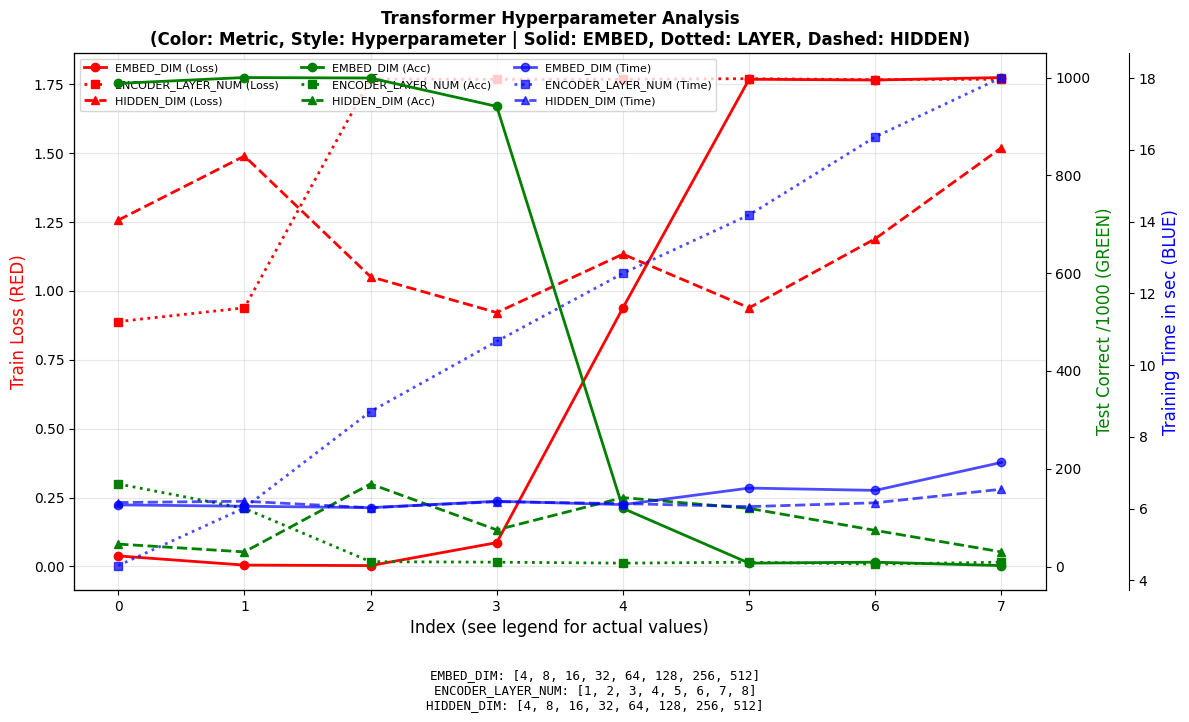

In [14]:
# ============================================================
# Plotting - Single Figure with 3 y-axes
# ============================================================
fig, ax1 = plt.subplots(figsize=(12, 7))

# Create additional y-axes
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))

# X-axis: use indices (0 to n-1)
n = len(embed_dims)
x_indices = list(range(n))

# Plot Train Loss (RED) - Left y-axis
# Solid: EMBED_DIM, Dotted: ENCODER_LAYER_NUM, Dashed: HIDDEN_DIM
l1 = ax1.plot(x_indices, losses_embed, 'r-o', linewidth=2, markersize=6, label='EMBED_DIM (Loss)')
l2 = ax1.plot(x_indices, losses_encoder, 'r:s', linewidth=2, markersize=6, label='ENCODER_LAYER_NUM (Loss)')
l3 = ax1.plot(x_indices, losses_hidden, 'r--^', linewidth=2, markersize=6, label='HIDDEN_DIM (Loss)')

# Plot Test Accuracy (GREEN) - Right y-axis 1
l4 = ax2.plot(x_indices, accs_embed, 'g-o', linewidth=2, markersize=6, label='EMBED_DIM (Acc)')
l5 = ax2.plot(x_indices, accs_encoder, 'g:s', linewidth=2, markersize=6, label='ENCODER_LAYER_NUM (Acc)')
l6 = ax2.plot(x_indices, accs_hidden, 'g--^', linewidth=2, markersize=6, label='HIDDEN_DIM (Acc)')

# Plot Training Time (BLUE) - Right y-axis 2
l7 = ax3.plot(x_indices, times_embed, 'b-o', linewidth=2, markersize=6, alpha=0.7, label='EMBED_DIM (Time)')
l8 = ax3.plot(x_indices, times_encoder, 'b:s', linewidth=2, markersize=6, alpha=0.7, label='ENCODER_LAYER_NUM (Time)')
l9 = ax3.plot(x_indices, times_hidden, 'b--^', linewidth=2, markersize=6, alpha=0.7, label='HIDDEN_DIM (Time)')

# Labels
ax1.set_xlabel('Index (see legend for actual values)', fontsize=12)
ax1.set_ylabel('Train Loss (RED)', fontsize=12, color='red')
ax2.set_ylabel('Test Correct /1000 (GREEN)', fontsize=12, color='green')
ax3.set_ylabel('Training Time in sec (BLUE)', fontsize=12, color='blue')

# Set x-axis ticks
ax1.set_xticks(x_indices)
ax1.set_xticklabels([f'{i}' for i in x_indices])

# Add text annotation for actual values
embed_str   = f"EMBED_DIM: {embed_dims}"
encoder_str = f"ENCODER_LAYER_NUM: {encoder_layers}"
hidden_str  = f"HIDDEN_DIM: {hidden_dims}"
fig.text(0.5, -0.02, f"{embed_str}\n{encoder_str}\n{hidden_str}", 
         ha='center', fontsize=9, family='monospace')

# Combine legends
lines  = l1 + l2 + l3 + l4 + l5 + l6 + l7 + l8 + l9
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=8, ncol=3)

ax1.grid(True, alpha=0.3)
plt.title('Transformer Hyperparameter Analysis\n(Color: Metric, Style: Hyperparameter | Solid: EMBED, Dotted: LAYER, Dashed: HIDDEN)', 
          fontsize=12, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

## 3.2. SOTA model analysis

In [48]:
import time
import numpy as np

# ============================================================
# Exhaustive Evaluation: All 10000 cases
# ============================================================

# Load Transformer SOTA
# model = MyTransformer(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, ENCODER_LAYER_NUM).to(DEVICE)
# model.load_state_dict(torch.load('model/transformer_sota.pth'))
# model.eval()
# print("Transformer SOTA model loaded.")


model.eval()

x_values      = []  # num1 * 100 + num2 (0 ~ 9999)
y_values      = []  # deviation (true - pred)
true_labels   = []
pred_labels   = []

start_time = time.time()

with torch.no_grad():
    for num11 in tq(range(10), desc="Exhaustive Test"):
        for num12 in range(10):
            for num21 in range(10):
                for num22 in range(10):
                    # Create input
                    num1 = num11 * 10 + num12
                    num2 = num21 * 10 + num22
                    true_sum = num1 + num2
                    
                    # Prepare input tensor
                    src = torch.tensor([[num11, num12, num21, num22]], dtype=torch.long).to(DEVICE)
                    
                    # Predict
                    logits = model(src)
                    preds  = logits.argmax(-1)  # (1, 3)
                    
                    # Convert prediction to number
                    pred_digits = preds[0].cpu().tolist()
                    pred_sum    = pred_digits[0] * 100 + pred_digits[1] * 10 + pred_digits[2]
                    
                    # Store results
                    x_values.append(num1 * 100 + num2)  # 0 ~ 9999
                    y_values.append(true_sum - pred_sum)  # deviation
                    true_labels.append(true_sum)
                    pred_labels.append(pred_sum)

total_time = time.time() - start_time

# ============================================================
# Calculate Metrics
# ============================================================
x_values    = np.array(x_values)
y_values    = np.array(y_values)
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Correct predictions
correct = np.sum(y_values == 0)
total   = len(y_values)

# Precision & Recall
precision = correct / total if total > 0 else 0
recall    = correct / total if total > 0 else 0

# Deviation statistics
dev_mean = np.mean(y_values)
dev_std  = np.std(y_values)

print("\n" + "=" * 60)
print("SOTA Transformer Model - Exhaustive Test Results")
print("=" * 60)
print(f"Total computation time:    {total_time:.4f} seconds")
print(f"Time per iteration:        {total_time / total * 1000:.4f} ms")
print(f"Precision:                 {precision * 100:.2f}% ({correct}/{total})")
print(f"Recall:                    {recall * 100:.2f}%")
print(f"Deviation mean:            {dev_mean:.4f}")
print(f"Deviation std:             {dev_std:.4f}")
print("=" * 60)

Exhaustive Test: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


SOTA Transformer Model - Exhaustive Test Results
Total computation time:    14.3153 seconds
Time per iteration:        1.4315 ms
Precision:                 100.00% (10000/10000)
Recall:                    100.00%
Deviation mean:            0.0000
Deviation std:             0.0000


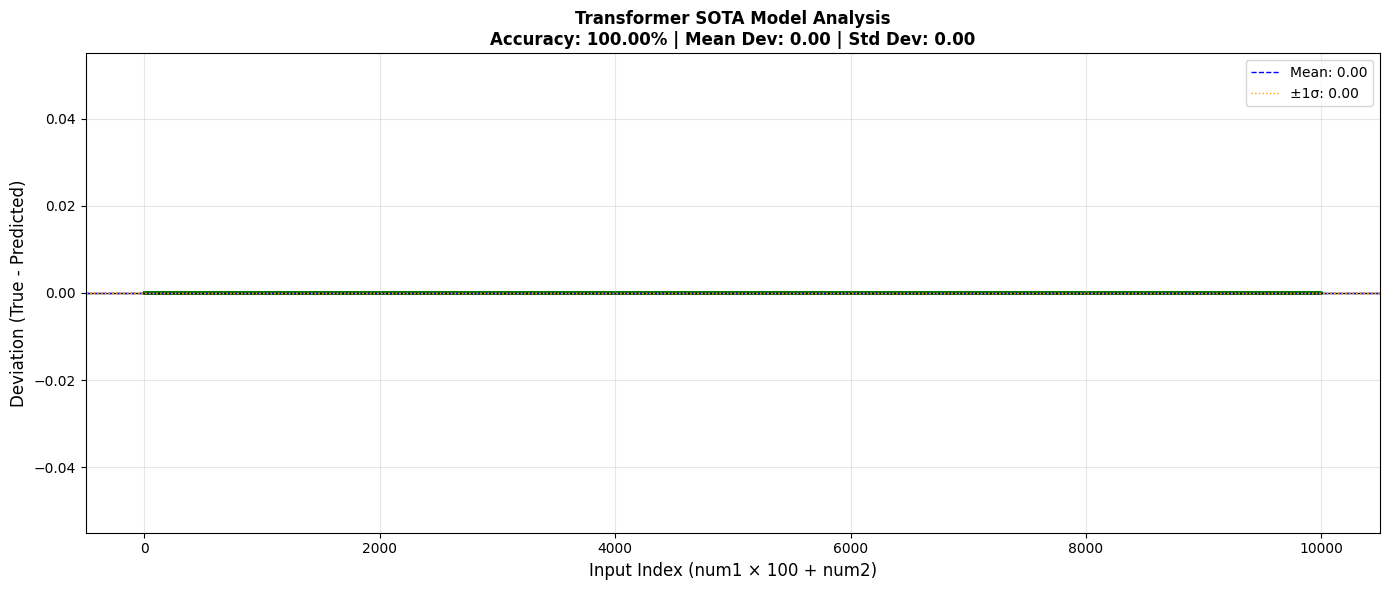


Sample Error Cases (first 10):
--------------------------------------------------


In [ ]:
import matplotlib.pyplot as plt

# ============================================================
# Plotting
# ============================================================
fig, ax = plt.subplots(figsize=(14, 6))

# Scatter plot: x = num1*100 + num2 (0~9999), y = deviation
colors = ['green' if d == 0 else 'red' for d in y_values]
ax.scatter(x_values, y_values, c=colors, alpha=0.5, s=3)

ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.axhline(y=dev_mean, color='blue', linestyle='--', linewidth=1, label=f'Mean: {dev_mean:.2f}')
ax.axhline(y=dev_mean + dev_std, color='orange', linestyle=':', linewidth=1, label=f'±1σ: {dev_std:.2f}')
ax.axhline(y=dev_mean - dev_std, color='orange', linestyle=':', linewidth=1)

ax.set_xlabel('Input Index (num1 × 100 + num2)', fontsize=12)
ax.set_ylabel('Deviation (True - Predicted)', fontsize=12)
ax.set_title(f'Transformer SOTA Model Analysis\nAccuracy: {precision*100:.2f}% | Mean Dev: {dev_mean:.2f} | Std Dev: {dev_std:.2f}', 
             fontsize=12, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show some error examples
print("\nSample Error Cases (first 10):")
print("-" * 50)
error_indices = np.where(y_values != 0)[0][:10]
for idx in error_indices:
    num1 = x_values[idx] // 100
    num2 = x_values[idx] % 100
    print(f"{num1:2d} + {num2:2d} = {true_labels[idx]:3d} | Pred: {pred_labels[idx]:3d} | Dev: {y_values[idx]:+4d}")


## 3.2. Transformer vs CNN SOTA model analysis

In [6]:
import time
import numpy as np

# ============================================================
# Load Both SOTA Models
# ============================================================

# Load Transformer SOTA
transformer_model = MyTransformer(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, ENCODER_LAYER_NUM).to(DEVICE)
transformer_model.load_state_dict(torch.load('model/85%_transformer_4096_2_64.pth'))
transformer_model.eval()
print("Transformer SOTA model loaded.")

# For CNN, you need to define CNN hyperparameters (adjust as needed)
CNN_EMBED_DIM      = 4096  # Adjust to your CNN SOTA values
CNN_CONV_LAYER_NUM = 2
CNN_NUM_CHANNELS   = 64

# Need to import/define MyCNN if not already available
# Assuming MyCNN is defined or imported

cnn_model = MyCNN(VOCAB_SIZE, CNN_EMBED_DIM, CNN_NUM_CHANNELS, CNN_CONV_LAYER_NUM).to(DEVICE)
cnn_model.load_state_dict(torch.load('model/76%_cnn_4096_2_64.pth'))
cnn_model.eval()
print("CNN SOTA model loaded.")

# ============================================================
# Exhaustive Evaluation: All 10000 cases for both models
# ============================================================

transformer_deviations = []
cnn_deviations         = []

start_time = time.time()

with torch.no_grad():
    for num11 in tq(range(10), desc="Exhaustive Test"):
        for num12 in range(10):
            for num21 in range(10):
                for num22 in range(10):
                    # Create input
                    num1     = num11 * 10 + num12
                    num2     = num21 * 10 + num22
                    true_sum = num1 + num2
                    
                    # Prepare input tensor
                    src = torch.tensor([[num11, num12, num21, num22]], dtype=torch.long).to(DEVICE)
                    
                    # Transformer prediction
                    logits_t     = transformer_model(src)
                    preds_t      = logits_t.argmax(-1)[0].cpu().tolist()
                    pred_sum_t   = preds_t[0] * 100 + preds_t[1] * 10 + preds_t[2]
                    transformer_deviations.append(true_sum - pred_sum_t)
                    
                    # CNN prediction
                    logits_c     = cnn_model(src)
                    preds_c      = logits_c.argmax(-1)[0].cpu().tolist()
                    pred_sum_c   = preds_c[0] * 100 + preds_c[1] * 10 + preds_c[2]
                    cnn_deviations.append(true_sum - pred_sum_c)

total_time = time.time() - start_time

transformer_deviations = np.array(transformer_deviations)
cnn_deviations         = np.array(cnn_deviations)

# ============================================================
# Calculate Metrics
# ============================================================
transformer_correct = np.sum(transformer_deviations == 0)
cnn_correct         = np.sum(cnn_deviations == 0)
total               = len(transformer_deviations)

print("\n" + "=" * 60)
print("SOTA Model Comparison - Exhaustive Test Results")
print("=" * 60)
print(f"Total computation time:    {total_time:.4f} seconds")
print(f"Time per iteration:        {total_time / total * 1000:.4f} ms")
print("-" * 60)
print(f"Transformer Accuracy:      {transformer_correct / total * 100:.2f}% ({transformer_correct}/{total})")
print(f"CNN Accuracy:              {cnn_correct / total * 100:.2f}% ({cnn_correct}/{total})")
print("=" * 60)

Transformer SOTA model loaded.
CNN SOTA model loaded.


Exhaustive Test: 100%|██████████| 10/10 [05:54<00:00, 35.47s/it]


SOTA Model Comparison - Exhaustive Test Results
Total computation time:    354.6828 seconds
Time per iteration:        35.4683 ms
------------------------------------------------------------
Transformer Accuracy:      84.48% (8448/10000)
CNN Accuracy:              78.49% (7849/10000)


/var/folders/fg/w98q2k8d1w31xss_6xdh683h0000gn/T/ipykernel_51804/761147154.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([transformer_deviations, cnn_deviations],


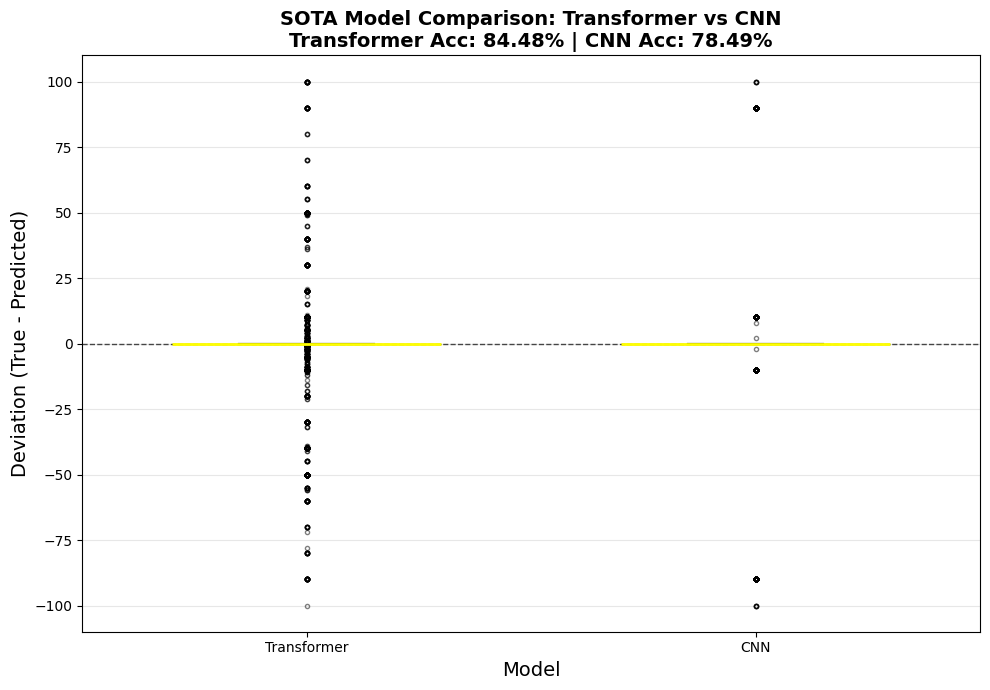

In [8]:
import matplotlib.pyplot as plt

# ============================================================
# Box Plot Comparison
# ============================================================
fig, ax = plt.subplots(figsize=(10, 7))

# Create box plot
bp = ax.boxplot([transformer_deviations, cnn_deviations], 
                labels=['Transformer', 'CNN'],
                patch_artist=True,
                widths=0.6)

# Set colors: Transformer = Red, CNN = Blue
colors = ['red', 'blue']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

# Style whiskers, caps, medians
for whisker in bp['whiskers']:
    whisker.set(color='black', linewidth=1.5)
for cap in bp['caps']:
    cap.set(color='black', linewidth=1.5)
for median in bp['medians']:
    median.set(color='yellow', linewidth=2)
for flier in bp['fliers']:
    flier.set(marker='o', markersize=3, alpha=0.5)

ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.7)

ax.set_xlabel('Model', fontsize=14)
ax.set_ylabel('Deviation (True - Predicted)', fontsize=14)
ax.set_title(f'SOTA Model Comparison: Transformer vs CNN\n'
             f'Transformer Acc: {transformer_correct/total*100:.2f}% | CNN Acc: {cnn_correct/total*100:.2f}%', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 3.3. Transformer vs CNN loss comparison

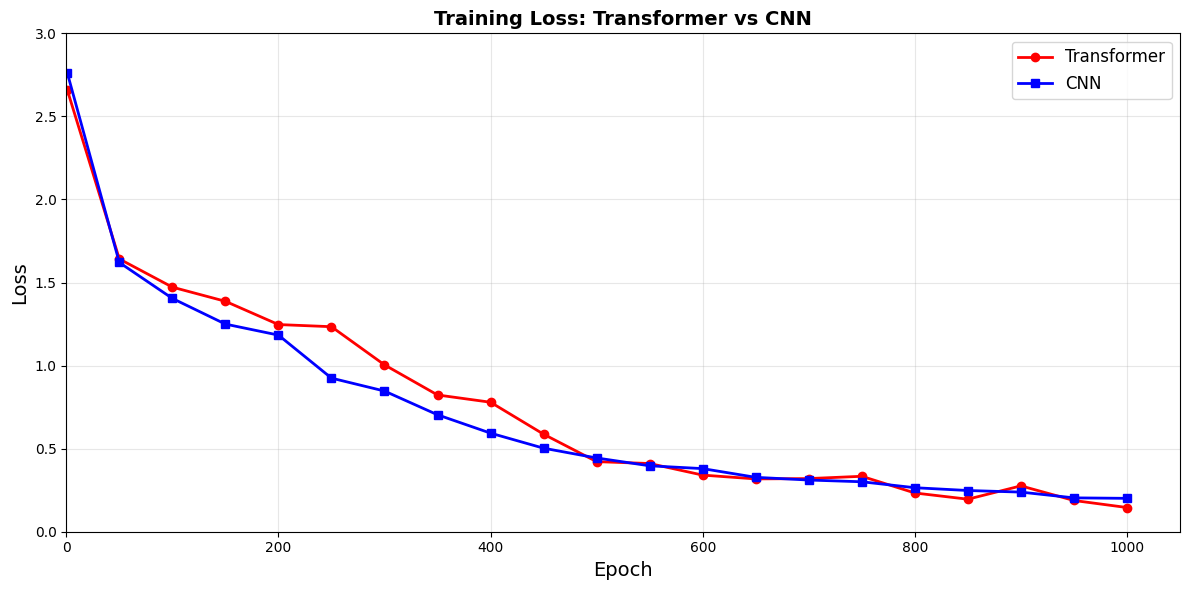

In [10]:
import matplotlib.pyplot as plt

# Transformer loss data (epochs, loss)
transformer_epochs = [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
transformer_loss   = [2.6582, 1.6419, 1.4722, 1.3870, 1.2470, 1.2341, 1.0044, 0.8232, 0.7794, 0.5870, 0.4219, 0.4105, 0.3408, 0.3179, 0.3199, 0.3337, 0.2332, 0.1958, 0.2760, 0.1880, 0.1457]

# CNN loss data (epochs, loss)
cnn_epochs = [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
cnn_loss   = [2.7611, 1.6207, 1.4044, 1.2498, 1.1835, 0.9246, 0.8468, 0.7039, 0.5934, 0.5028, 0.4440, 0.3968, 0.3799, 0.3274, 0.3111, 0.3007, 0.2649, 0.2481, 0.2385, 0.2038, 0.2009]

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(transformer_epochs, transformer_loss, 'r-o', linewidth=2, markersize=6, label='Transformer')
ax.plot(cnn_epochs, cnn_loss, 'b-s', linewidth=2, markersize=6, label='CNN')

ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.set_title('Training Loss: Transformer vs CNN', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=12)
ax.grid(True, alpha=0.3)

ax.set_xlim(0, 1050)
ax.set_ylim(0, 3)

plt.tight_layout()
plt.show()

## 3.4. frequent deviations

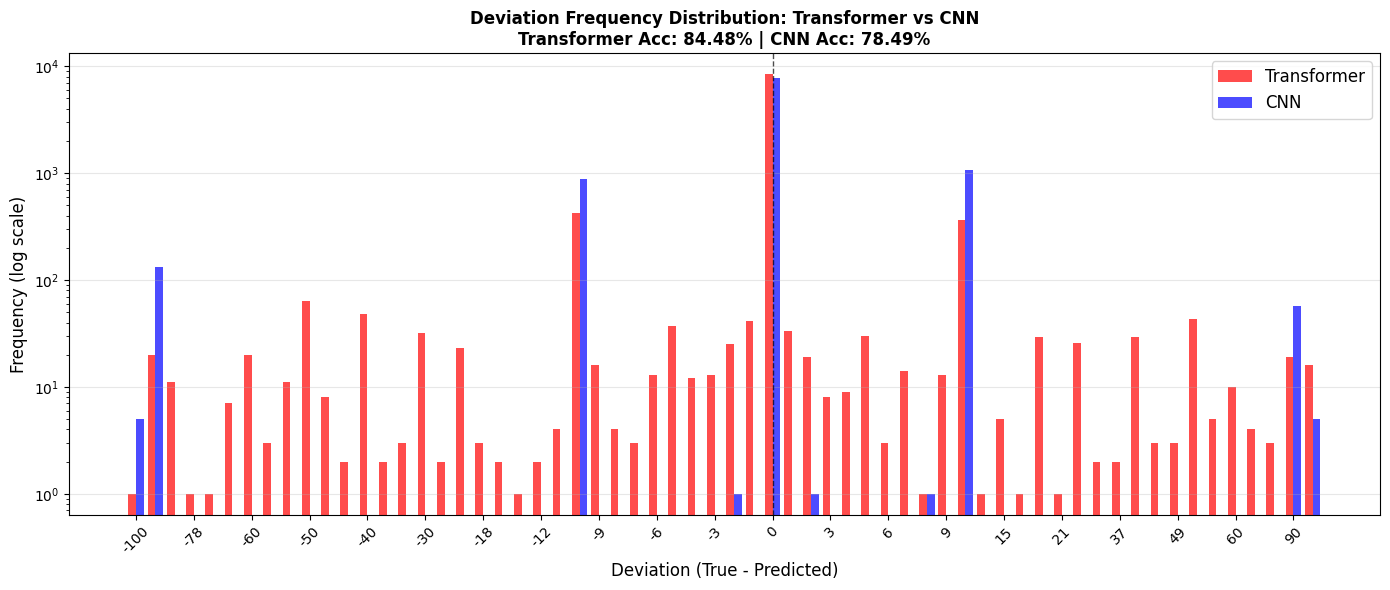


Top 5 Most Frequent Deviations:
--------------------------------------------------
Transformer:
  Deviation   +0:  8448 (84.48%)
  Deviation  -10:   423 (4.23%)
  Deviation  +10:   363 (3.63%)
  Deviation  -50:    63 (0.63%)
  Deviation  -40:    48 (0.48%)

CNN:
  Deviation   +0:  7849 (78.49%)
  Deviation  +10:  1070 (10.70%)
  Deviation  -10:   878 (8.78%)
  Deviation  -90:   133 (1.33%)
  Deviation  +90:    57 (0.57%)


In [12]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Count frequencies
transformer_counts = Counter(transformer_deviations)
cnn_counts         = Counter(cnn_deviations)

# Get all unique deviation values
all_deviations = sorted(set(transformer_deviations) | set(cnn_deviations))

# Get counts for each deviation value
transformer_freq = [transformer_counts.get(d, 0) for d in all_deviations]
cnn_freq         = [cnn_counts.get(d, 0) for d in all_deviations]

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

width = 0.4
x = np.arange(len(all_deviations))

ax.bar(x - width/2, transformer_freq, width, color='red', alpha=0.7, label='Transformer')
ax.bar(x + width/2, cnn_freq, width, color='blue', alpha=0.7, label='CNN')

ax.set_yscale('log')
ax.set_xlabel('Deviation (True - Predicted)', fontsize=12)
ax.set_ylabel('Frequency (log scale)', fontsize=12)
ax.set_title(f'Deviation Frequency Distribution: Transformer vs CNN\n'
             f'Transformer Acc: {transformer_correct/total*100:.2f}% | CNN Acc: {cnn_correct/total*100:.2f}%',
             fontsize=12, fontweight='bold')

# Set x-ticks (show every 10th label if too many)
if len(all_deviations) > 30:
    step = max(1, len(all_deviations) // 20)
    ax.set_xticks(x[::step])
    ax.set_xticklabels([str(d) for d in all_deviations[::step]], rotation=45)
else:
    ax.set_xticks(x)
    ax.set_xticklabels([str(d) for d in all_deviations], rotation=45)

ax.axvline(x=list(all_deviations).index(0) if 0 in all_deviations else 0, 
           color='black', linestyle='--', linewidth=1, alpha=0.7)
ax.legend(loc='upper right', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print top 5 most frequent deviations
print("\nTop 5 Most Frequent Deviations:")
print("-" * 50)
print("Transformer:")
for dev, count in transformer_counts.most_common(5):
    print(f"  Deviation {dev:+4d}: {count:5d} ({count/total*100:.2f}%)")
print("\nCNN:")
for dev, count in cnn_counts.most_common(5):
    print(f"  Deviation {dev:+4d}: {count:5d} ({count/total*100:.2f}%)")

# 4. Save the model.

In [46]:
import os

# Create directory if not exists
os.makedirs('model', exist_ok=True)

# Save Transformer SOTA model
torch.save(model.state_dict(), 'model/transformer_4_2_32_lr6e-3.pth')
print("Transformer SOTA model saved to model/transformer_4_2_32_lr6e-3.pth")

Transformer SOTA model saved to model/transformer_4_2_32_lr6e-3.pth




# 1. CNN Define.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm as tq


DIGITS     = ['0','1','2','3','4','5','6','7','8','9']
VOCAB_SIZE = len(DIGITS)
DEVICE     = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

# Fixed hyperparameters
INPUT_LEN     = 4
OUTPUT_LEN    = 3
LEARNING_RATE = 1e-4
NUM_EPOCH     = 1000
BATCH_SIZE    = 128

# Changable hyperparameters
EMBED_DIM      = 1024
CONV_LAYER_NUM = 16 
NUM_CHANNELS   = 32

char_to_idx = {c: i for i, c in enumerate(DIGITS)}
idx_to_char = {i: c for i, c in enumerate(DIGITS)}

# batch data generation
def generate_batch(batch_size=100):
    inputs, targets = [], []
    for _ in range(batch_size):
        tens1, ones1 = random.randint(0, 9), random.randint(0, 9)
        tens2, ones2 = random.randint(0, 9), random.randint(0, 9)
        num1, num2 = tens1 * 10 + ones1, tens2 * 10 + ones2
        s = num1 + num2
        inputs.append([tens1, ones1, tens2, ones2])
        sum_str = f"{s:03d}"
        targets.append([char_to_idx[c] for c in sum_str])
    return (torch.tensor(inputs, dtype=torch.long).to(DEVICE),
            torch.tensor(targets, dtype=torch.long).to(DEVICE))

# ReLU
def my_relu(x):
    return torch.clamp(x, min=0.0)

#------------------------------------
# 4 digits to one-hot vectors
#------------------------------------
def MyOneHot(x, vocab_size):    
    B, L = x.size()     # batch size x INPUT_LEN

    ############################################################################
    # TODO: Convert x to one-hot
    ############################################################################

    # Create zero tensor of shape (B, L, vocab_size)
    out = torch.zeros(B, L, vocab_size, device=x.device)
    # Use scatter to fill in the one-hot encoding
    out.scatter_(2, x.unsqueeze(2), 1.0)

    ############################################################################
    # END TODO
    ############################################################################

    return out   # B x L x vocab_size

#------------------------------------
# Embedding layer
#------------------------------------
class MyEmbedding(nn.Module):
    def __init__(self, vocab_size, dim):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(vocab_size, dim) * 0.1)

    def forward(self, x):
        B, L = x.size()

        ############################################################################
        # TODO: Convert x to one-hot and then embedding
        #    Use MyOneHot() function above
        ############################################################################

        # Convert to one-hot: (B, L, vocab_size)
        one_hot = MyOneHot(x, self.weight.size(0))
        # Matrix multiply with embedding weight: (B, L, vocab_size) @ (vocab_size, dim) = (B, L, dim)
        out = torch.matmul(one_hot, self.weight)
        
        ############################################################################
        # END TODO
        ############################################################################

        return out  # B x L x dim

#------------------------------------
# Linear layer
#------------------------------------
class MyLinear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_dim, in_dim) * 0.1)
        self.bias   = nn.Parameter(torch.zeros(out_dim))

    def forward(self, x):

        ############################################################################
        # TODO: Compute linear layer output
        #   You should implement your own linear layer operation.
        ############################################################################
            
        # x: (..., in_dim), weight: (out_dim, in_dim), bias: (out_dim)
        # out = x @ W^T + bias
        out = torch.matmul(x, self.weight.t()) + self.bias
        
        ############################################################################
        # END TODO
        ############################################################################

        return out  

#------------------------------------
# Conv layer
#------------------------------------
class MyConv2D(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3, padding=1):
        super().__init__()

        self.in_channel  = in_channel
        self.out_channel = out_channel
        self.kernel      = kernel_size
        self.pad         = padding
        
        self.weight = nn.Parameter(torch.randn(out_channel, in_channel, kernel_size, kernel_size) * 0.1)
        self.bias   = nn.Parameter(torch.zeros(out_channel))

    def forward(self, x):
        B, C, H, W = x.shape

        ############################################################################
        # TODO: 2D convolution operation
        #   You should implement your own convolution operation.
        ############################################################################

        # Pad the input
        if self.pad > 0:
            x_padded = torch.zeros(B, C, H + 2 * self.pad, W + 2 * self.pad, device=x.device)
            x_padded[:, :, self.pad:self.pad + H, self.pad:self.pad + W] = x
        else:
            x_padded = x
        
        H_pad, W_pad = x_padded.shape[2], x_padded.shape[3]
        
        # Output dimensions (stride=1)
        H_out = H_pad - self.kernel + 1
        W_out = W_pad - self.kernel + 1
        
        # Initialize output
        out = torch.zeros(B, self.out_channel, H_out, W_out, device=x.device)
        
        # Perform convolution
        for i in range(H_out):
            for j in range(W_out):
                # Extract patch: (B, C, kernel, kernel)
                patch = x_padded[:, :, i:i + self.kernel, j:j + self.kernel]
                # patch: (B, in_channel, kernel, kernel)
                # weight: (out_channel, in_channel, kernel, kernel)
                # Compute convolution for all output channels at once
                for oc in range(self.out_channel):
                    # Sum over in_channel, kernel_h, kernel_w
                    out[:, oc, i, j] = (patch * self.weight[oc]).sum(dim=(1, 2, 3)) + self.bias[oc]

        ############################################################################
        # END TODO
        ############################################################################

        return out  # B x out_ch x H x W

#------------------------------------
# CNN model
#------------------------------------
class MyCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_channels, num_conv_layers):
        super().__init__()

        ############################################################################
        # TODO: Define each layer (embedding, conv1, conv2, ..., fc)
        #     Use MyEmbedding, MyConv2D, MyLinear classes defined above.
        ############################################################################
        
        self.embed_dim       = embed_dim
        self.num_channels    = num_channels
        self.num_conv_layers = num_conv_layers
        
        # Embedding layer
        self.embedding = MyEmbedding(vocab_size, embed_dim)
        
        # Conv layers using nn.ModuleList for dynamic number of layers
        self.conv_layers = nn.ModuleList()
        for i in range(num_conv_layers):
            if i == 0:
                # First conv: in_channel = embed_dim, out_channel = num_channels
                self.conv_layers.append(MyConv2D(embed_dim, num_channels, kernel_size=3, padding=1))
            else:
                # Subsequent convs: in_channel = num_channels, out_channel = num_channels
                self.conv_layers.append(MyConv2D(num_channels, num_channels, kernel_size=3, padding=1))
        
        # FC layer: input is flattened conv output (2 * 2 * num_channels), output is 3 * VOCAB_SIZE
        self.fc = MyLinear(2 * 2 * num_channels, OUTPUT_LEN * vocab_size)

        ############################################################################
        # END TODO
        ############################################################################

    def forward(self, x):
        B = x.size(0)

        ############################################################################
        # TODO: Define forward path: 
        #    embedding -> reshape -> conv1 -> ReLU -> conv2 -> ReLU -> ... -> flatten -> fc
        ############################################################################

        # Embedding: (B, 4) -> (B, 4, embed_dim)
        out = self.embedding(x)

        # Reshape to image-like: (B, 4, embed_dim) -> (B, embed_dim, 2, 2)
        out = out.permute(0, 2, 1)  # (B, embed_dim, 4)
        out = out.view(B, self.embed_dim, 2, 2)  # (B, embed_dim, 2, 2)
        
        # Apply conv layers with ReLU
        for conv in self.conv_layers:
            out = conv(out)  # (B, num_channels, 2, 2)
            out = my_relu(out)
        
        # Flatten
        out = out.view(B, -1)  # (B, 2*2*num_channels)
        
        # FC layer
        out = self.fc(out)  # (B, 3*VOCAB_SIZE)
        
        # Reshape to (B, 3, VOCAB_SIZE)
        out = out.view(B, OUTPUT_LEN, VOCAB_SIZE)

        ############################################################################
        # END TODO
        ############################################################################

        return out    # B x 3 x VOCAB_SIZE

